In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
class RVM:

    def __init__(self, x, y, r) -> None:
        self.r = r
        self.x = x
        self.y = y
        self.r = r
        self.n = len(x)
        self.Phi = self.PhiMatrix()
        

    def phi(self, x, xi):
        return np.exp(-(x - xi)**2 / (self.r ** 2))
    
    def PhiMatrix(self):
        Phi = np.empty((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                Phi[i, j] = self.phi(self.x[i], self.x[j])
        return Phi
    
    def SigmaMatrix(self, alpha, beta):
        return np.linalg.inv(np.diag(alpha) + beta * (self.Phi @ self.Phi.T))

    def m(self, beta, Sigma):
        return beta * Sigma @ self.Phi.T @ self.y

    def Regression(self, alpha_initial, beta_initial, alpha_thresh, delta_thresh):
        alpha = alpha_initial
        beta = beta_initial
        delta = delta_thresh + 1 #So it enters the loop initially
        pruning_bool = np.ones_like(alpha) #pruning_bool[i] = 0 iff alpha_i was pruned
        while delta > delta_thresh:
            Sigma = self.SigmaMatrix(alpha, beta)
            m = self.m(beta, Sigma)
            gamma = 1 - alpha * np.diag(Sigma)
            prev_alpha = alpha
            alpha = gamma / (m ** 2)
            alpha *= pruning_bool
            beta = (self.n - np.sum(gamma)) / (np.linalg.norm(self.y - self.Phi @ m) ** 2)
            delta = np.linalg.norm(alpha - prev_alpha, 1)
            pruning_bool[alpha > alpha_thresh] = 0 
            alpha[alpha > alpha_thresh] = 0

        return alpha, beta, pruning_bool
    
    def Predict(self, x_star, alpha, beta, pruning_bool):
        m = self.m(beta, self.SigmaMatrix(alpha, beta))
        phi_vector = np.array([self.phi(x_star, self.x[i]) for i in range(self.n)]) * pruning_bool
        y_star = np.dot(m, phi_vector)
        return y_star

# Regression Model Example
Testing on the function $f(x) = x^3$, from which 50 samples are taken on the interval $[-10, 10]$. </br> The parameters are: $r = 0.4, \; \alpha_\text{thresh} = 100, \; \delta_\text{thresh} = 0.0001, \; \beta_0 = 1, \; \alpha_0 = (1,\ldots,1)^T$. </br>
We plot the Regression Model but with 5000 taken samples.

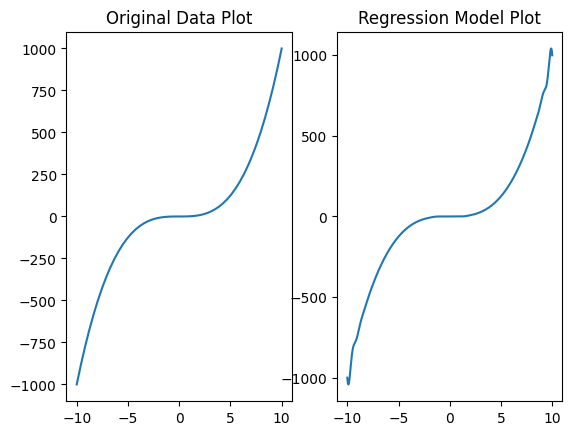

In [24]:
a = -10
b = 10
n = 50
r = (b - a) / n
x = np.linspace(a, b, n)
y = x ** 3
plt.subplot(121)
plt.title("Original Data Plot")
plt.plot(x, y)
machine = RVM(x, y, r)
alpha, beta, pruning_bool = machine.Regression(np.ones_like(x), 5, 100, 0.0001)
x = np.linspace(a, b, 100 * n) #Taking more samples to see how good the interpolation is
vectorized_predict = np.vectorize(lambda x_star: machine.Predict(x_star, alpha, beta, pruning_bool))
y = vectorized_predict(x)
plt.subplot(122)
plt.title("Regression Model Plot")
plt.plot(x, y)
plt.show()